# **Unsupervised Learning Clustering and Recommendations: Amazon apparels data review**

**Group Number:** 97  
**Members:**  
Roy Rui #300176548  
Jiayi Ma #300263220
 



## **Introduction**








## Dataset: Amazon apparels data review
**Author**: theKen Jin   
**Ref**:  [Source](https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata)  
**Shape**:   
**Description**:  






**General Imports**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler



# **Dataset**  
### **Load Dataset**  

In [72]:
# Load the datasets
amazon_clothing = pd.read_csv("dataset/Amazon-clothing-info.csv")
clothing_review = pd.read_csv("dataset/Clothing-Reviews.csv")

In [73]:
# 2. Inspect Initial Data
print("amazon_clothing columns:")
print(amazon_clothing.columns)
print("\nFirst 5 rows:")
print(amazon_clothing.head())

print("\nclothing_review columns:")
print(clothing_review.columns)
print("\nFirst 5 rows:")
print(clothing_review.head())


# 3. Data Cleaning
# Remove duplicates by 'asin'
amazon_clothing_clean = amazon_clothing.drop_duplicates(subset='asin')

# Handle 'price' column
if 'price' not in amazon_clothing_clean.columns:
    if 'Price' in amazon_clothing_clean.columns:
        amazon_clothing_clean.rename(columns={'Price': 'price'}, inplace=True)
        print("Renamed 'Price' to 'price'")
    else:
        print("No 'price' column found.")

if 'price' in amazon_clothing_clean.columns:
    amazon_clothing_clean['price'] = pd.to_numeric(amazon_clothing_clean['price'], errors='coerce')
    median_price = amazon_clothing_clean['price'].median()
    amazon_clothing_clean['price'] = amazon_clothing_clean['price'].fillna(median_price)
    print("Processed 'price' column.")
else:
    amazon_clothing_clean['price'] = np.nan

# Review data cleaning
print("\nReview sample:")
print(clothing_review.head())
print("\nMissing values in review data:")
print(clothing_review.isnull().sum())

# Keep review scores between 1 and 5
clothing_review = clothing_review[(clothing_review['review_score'] >= 1) & 
                                  (clothing_review['review_score'] <= 5)]


# 4. EDA & Outlier Detection
if 'price' in amazon_clothing_clean.columns and amazon_clothing_clean['price'].notnull().all():
    # Histogram
    plt.figure(figsize=(8,6))
    sns.histplot(amazon_clothing_clean['price'], bins=50, kde=True)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot
    plt.figure(figsize=(8,6))
    sns.boxplot(x=amazon_clothing_clean['price'])
    plt.title('Price Boxplot')
    plt.xlabel('Price')
    plt.show()

    # LOF outlier detection
    price_values = amazon_clothing_clean['price'].values.reshape(-1, 1)
    lof = LocalOutlierFactor(n_neighbors=20)
    outlier_flags = lof.fit_predict(price_values)
    amazon_clothing_clean['price_outlier'] = outlier_flags
    print(f"\nPrice outliers detected: {(outlier_flags == -1).sum()}")

    # Scatter with outliers
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=range(len(amazon_clothing_clean)), y='price', 
                    hue='price_outlier', data=amazon_clothing_clean,
                    palette={1:'blue', -1:'red'})
    plt.title('Outlier Detection in Prices')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.show()
else:
    print("Skipping EDA for 'price'.")

# 5. Feature Engineering
# Aggregate review stats
reviews_agg = clothing_review.groupby('asin')['review_score'].agg(['mean', 'count']).reset_index()
reviews_agg.rename(columns={'mean': 'avg_review_score', 'count': 'review_count'}, inplace=True)

# Merge with product data
merged_data = pd.merge(amazon_clothing_clean, reviews_agg, on='asin', how='left')
merged_data['avg_review_score'] = merged_data['avg_review_score'].fillna(0)
merged_data['review_count'] = merged_data['review_count'].fillna(0)

# Price per review
if 'price' in merged_data.columns and merged_data['price'].notnull().all():
    merged_data['price_per_review'] = merged_data['price'] / (merged_data['review_count'] + 1)
else:
    merged_data['price_per_review'] = np.nan

# One-hot encode color
if 'color' in merged_data.columns:
    merged_data = pd.get_dummies(merged_data, columns=['color'], dummy_na=True)

# Preview merged data
print("\nMerged data preview:")
print(merged_data.head())



amazon_clothing columns:
Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

First 5 rows:
                    sku        asin product_type_name formatted_price author  \
0                   NaN  B004GSI2OS             SHIRT          $26.26    NaN   
1                   NaN  B012YX2ZPI             SHIRT           $9.99    NaN   
2                   NaN  B001LOUGE4             SHIRT          $11.99    NaN   
3  HT-2001_Lime-1149-XL  B003BSRPB0             SHIRT          $20.54    NaN   
4                   NaN  B014ICEDNA             SHIRT           $7.50    NaN   

               color                        brand publisher  \
0  Onyx Black/ Stone                  FeatherLite       NaN   
1              Whit

== Amazon Clothing Info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28395 entries, 0 to 28394
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sku                134 non-null    object
 1   asin               28395 non-null  object
 2   product_type_name  28395 non-null  object
 3   formatted_price    28395 non-null  object
 4   author             1 non-null      object
 5   color              28385 non-null  object
 6   brand              28302 non-null  object
 7   publisher          8341 non-null   object
 8   availability       24532 non-null  object
 9   reviews            28395 non-null  object
 10  large_image_url    28395 non-null  object
 11  availability_type  24559 non-null  object
 12  small_image_url    28395 non-null  object
 13  editorial_review   441 non-null    object
 14  title              28395 non-null  object
 15  model              8282 non-null   object
 16  medium_image_

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,NaN,B004GSI2OS,SHIRT,$26.26,NaN,Onyx Black/ Stone,FeatherLite,NaN,Usually ships in 6-10 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,NaN,Featherlite Ladies' Long Sleeve Stain Resistan...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
1,NaN,B012YX2ZPI,SHIRT,$9.99,NaN,White,HX-Kingdom Fashion T-shirts,NaN,Usually ships in 4-5 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,This Personalized Special Olympics World Games...,Women's Unique 100% Cotton T - Special Olympic...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
2,NaN,B001LOUGE4,SHIRT,$11.99,NaN,Black,Fitness Etc.,NaN,NaN,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,NaN,https://images-na.ssl-images-amazon.com/images...,Light Weight 2x1 Boy Beater Tank Top. Great t...,Ladies Cotton Tank 2x1 Ribbed Tank Top,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
3,HT-2001_Lime-1149-XL,B003BSRPB0,SHIRT,$20.54,NaN,White,FeatherLite,NaN,Usually ships in 6-10 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite Ladies' Moisture Free Mesh Sport S...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
4,NaN,B014ICEDNA,SHIRT,$7.50,NaN,Purple,FNC7C,NaN,Usually ships in 4-5 business days,"[True, 'https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel Women...,Supernatural Chibis Sam Dean And Castiel Short...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN


,asin,title,review_userId,review_score,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...
2,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2F9LXG1QEJ855,4,Very Original Debut of one of the most striden...,"This is an early, and rough-sounding look at t..."
3,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2FGXHSHF0OD17,5,No secret here,Whats to say about this album? Quintessential ...
4,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2O2E8BLB7VW1U,5,Brings a smile to my face...,...Whenever i listing to an album by incantati...


Removed duplicates in amazon_clothing, original shape=(28395, 19), new shape=(28395, 19)

Filtered invalid review_score, original shape=(50046, 6), new shape=(50046, 6)

Missing values in amazon_clothing_clean:
sku                  28261
asin                     0
product_type_name        0
formatted_price          0
author               28394
color                   10
brand                   93
publisher            20054
availability          3863
reviews                  0
large_image_url          0
availability_type     3836
small_image_url          0
editorial_review     27954
title                    0
model                20113
medium_image_url         0
manufacturer         20054
editorial_reivew      2841
dtype: int64 

Missing values in valid_reviews:
asin                 0
title                0
review_userId        0
review_score         0
review_summary    2892
review_text          0
dtype: int64 



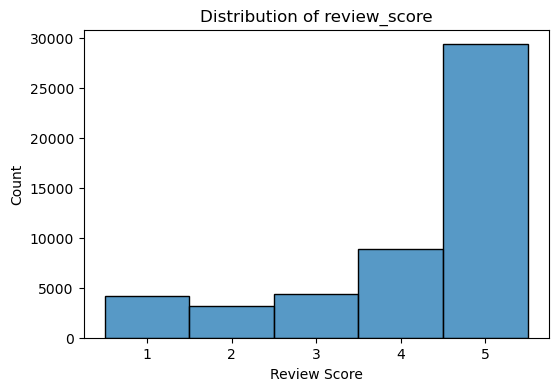

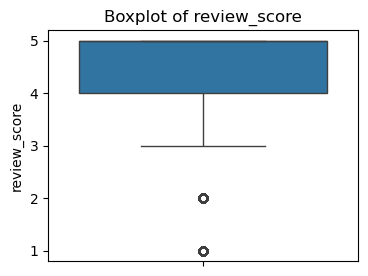

Number of detected outliers in 'review_score': 0


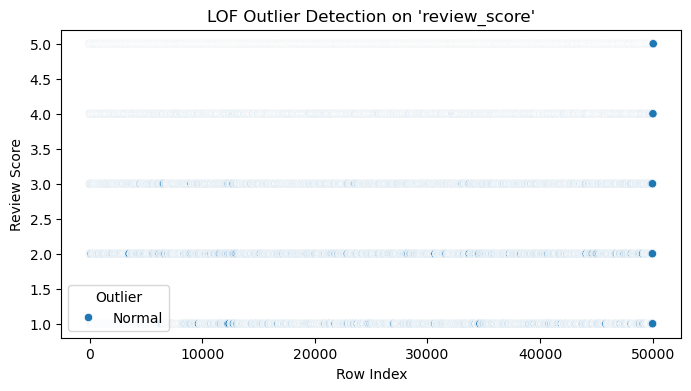

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import re

# 1) Load data
amazon_clothing = pd.read_csv("dataset/Amazon-clothing-info.csv")
clothing_review = pd.read_csv("dataset/Clothing-Reviews.csv")

# Basic info
print("== Amazon Clothing Info ==")
print(amazon_clothing.info(), "\n")

print("== Clothing Reviews ==")
print(clothing_review.info(), "\n")

# View sample rows
display(amazon_clothing.head())
display(clothing_review.head())

# 2) Data Cleaning
# 2.1 Remove duplicates (asin as unique key)
amazon_clothing_clean = amazon_clothing.drop_duplicates(subset='asin')
print(f"Original shape: {amazon_clothing.shape} -> After removing duplicates: {amazon_clothing_clean.shape}\n")

# 2.2 Filter review scores between 1 and 5
valid_reviews = clothing_review[
    (clothing_review['review_score'] >= 1) & (clothing_review['review_score'] <= 5)
]
print(f"Original reviews shape: {clothing_review.shape} -> After filtering: {valid_reviews.shape}\n")

# 2.3 Check missing values
print("Missing values in amazon_clothing_clean:")
print(amazon_clothing_clean.isnull().sum(), "\n")

print("Missing values in valid_reviews:")
print(valid_reviews.isnull().sum(), "\n")

# Example: fill missing 'review_summary' with 'Unknown'
if 'review_summary' in valid_reviews.columns:
    valid_reviews['review_summary'] = valid_reviews['review_summary'].fillna("Unknown")

# 3) Basic EDA
# Example: distribution of review_score
plt.figure(figsize=(6,4))
sns.histplot(valid_reviews['review_score'], bins=5, discrete=True)
plt.title("Distribution of review_score")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

# Example: boxplot of review_score
plt.figure(figsize=(4,3))
sns.boxplot(y=valid_reviews["review_score"])
plt.title("Boxplot of review_score")
plt.show()

# 4) Outlier Detection using LOF
# Example: using 'review_score' as numeric feature
filtered_reviews = valid_reviews.dropna(subset=['review_score'])

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
predictions = lof.fit_predict(filtered_reviews[['review_score']])

filtered_reviews["Outlier"] = (predictions == -1)
outliers_df = filtered_reviews[filtered_reviews["Outlier"]]
print(f"Number of detected outliers: {len(outliers_df)}")

# Visualization of LOF results
plt.figure(figsize=(8,4))
sns.scatterplot(
    x=filtered_reviews.index,
    y=filtered_reviews['review_score'],
    hue=filtered_reviews["Outlier"].map({False: "Normal", True: "Outlier"})
)
plt.title("LOF Outlier Detection on 'review_score'")
plt.xlabel("Index")
plt.ylabel("Review Score")
plt.show()

# Display some outliers if any
if len(outliers_df) > 0:
    display(outliers_df.head(10))


# Study 2 – Clustering Algorithms




=== Clustering on ['review_count', 'avg_review_score'] ===
Data shape after dropna: (28395, 2)


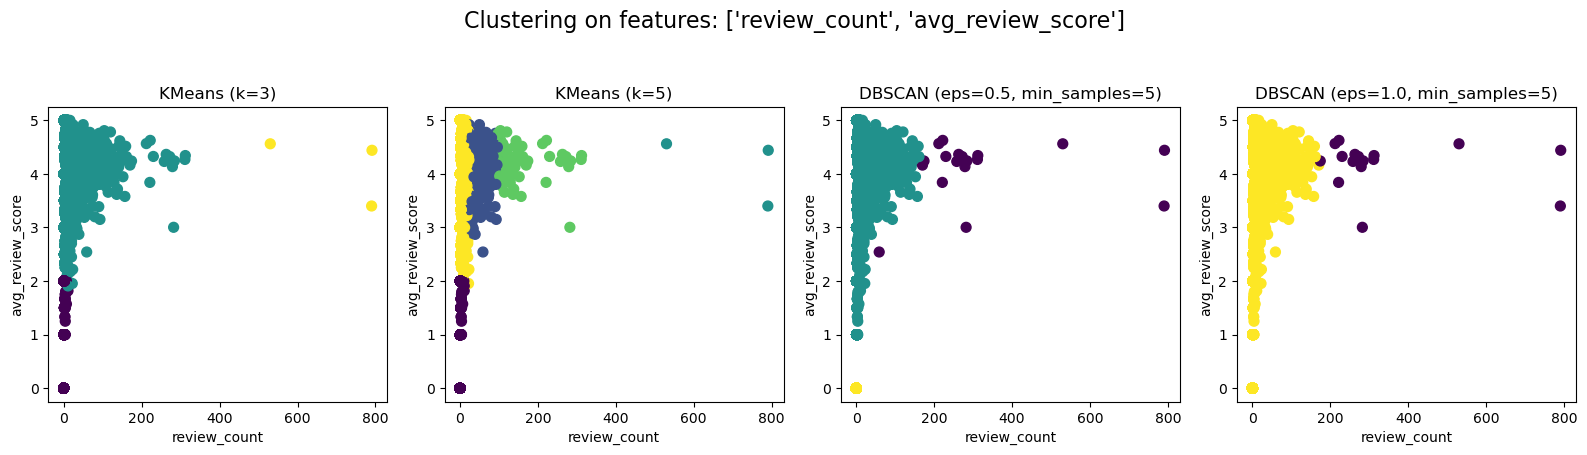


=== Clustering on ['price_numeric', 'review_count'] ===
Data shape after dropna: (28395, 2)


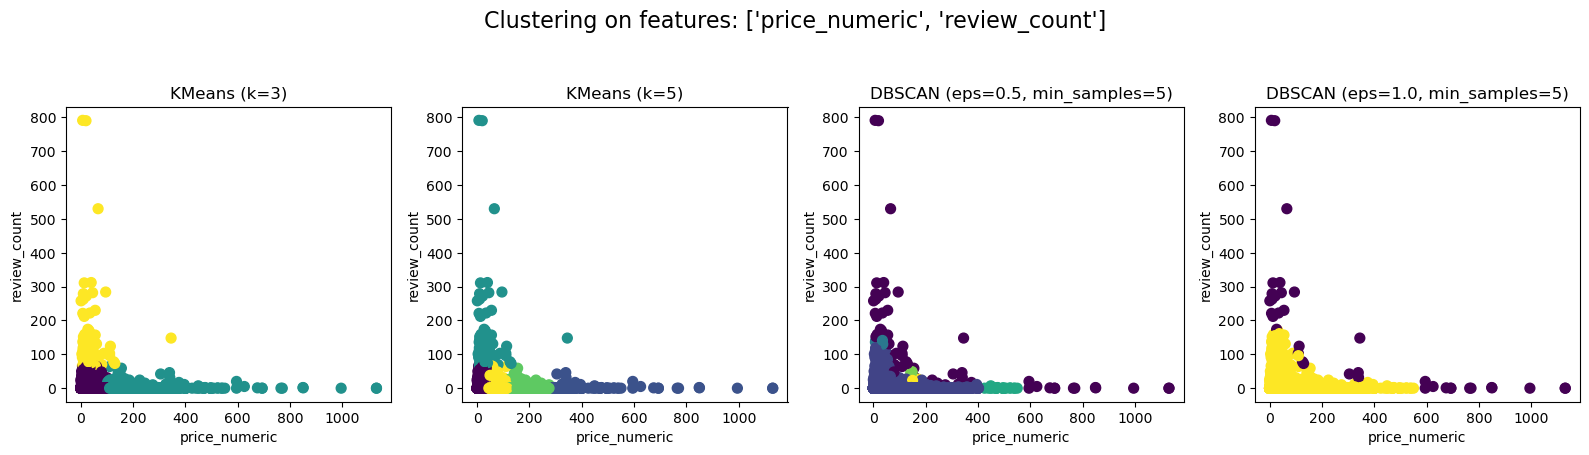

In [75]:
# Create a numeric price column from 'formatted_price' if it doesn't exist
if 'price_numeric' not in merged_data.columns:
    # Remove any non-digit and non-dot characters, then convert to float
    merged_data['price_numeric'] = merged_data['formatted_price'].str.replace(r'[^\d.]', '', regex=True)
    merged_data['price_numeric'] = pd.to_numeric(merged_data['price_numeric'], errors='coerce')

# Define two attribute combinations
attribute_combinations = [
    ['review_count', 'avg_review_score'],
    ['price_numeric', 'review_count']
]

# Define parameters for KMeans and DBSCAN
kmeans_params = [3, 5]
dbscan_params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 5}
]

# Loop over each attribute combination
for attrs in attribute_combinations:
    print(f"\n=== Clustering on {attrs} ===")
    
    # Verify required columns exist
    if not set(attrs).issubset(merged_data.columns):
        print(f"Columns {attrs} not found. Skipping.")
        continue
    
    # Extract and convert data to numeric
    data = merged_data[attrs].copy()
    for col in attrs:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Fill missing values with column medians and drop remaining NaNs
    for col in attrs:
        median_value = data[col].median()
        data[col] = data[col].fillna(median_value)
    data = data.dropna(subset=attrs)
    print("Data shape after dropna:", data.shape)
    if data.empty:
        print(f"No valid rows for {attrs}. Skipping.")
        continue

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    # Set up the plot
    num_plots = len(kmeans_params) + len(dbscan_params)
    plt.figure(figsize=(16, 8))
    plt.suptitle(f"Clustering on features: {attrs}", fontsize=16)
    
    # KMeans clustering
    for i, k in enumerate(kmeans_params):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        plt.subplot(2, num_plots, i + 1)
        plt.scatter(data[attrs[0]], data[attrs[1]], c=clusters, cmap='viridis', s=50)
        plt.title(f"KMeans (k={k})")
        plt.xlabel(attrs[0])
        plt.ylabel(attrs[1])
    
    # DBSCAN clustering
    for j, params in enumerate(dbscan_params):
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        clusters = dbscan.fit_predict(X_scaled)
        plt.subplot(2, num_plots, len(kmeans_params) + j + 1)
        plt.scatter(data[attrs[0]], data[attrs[1]], c=clusters, cmap='viridis', s=50)
        plt.title(f"DBSCAN (eps={params['eps']}, min_samples={params['min_samples']})")
        plt.xlabel(attrs[0])
        plt.ylabel(attrs[1])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Study 3 – Content-Based Recommendation System


In [76]:
# Heuristic 1: Brand and Price Similarity
# Products with the same brand and similar price are more alike.
def heuristic1(target, df, w_brand=0.5, w_price=0.5):
    brand_sim = (df['brand'] == target['brand']).astype(float)
    price_sim = 1 / (1 + abs(df['price_numeric'] - target['price_numeric']))
    return w_brand * brand_sim + w_price * price_sim

# Heuristic 2: Product Type and Review Score Similarity
# Products in the same category with similar review scores are more alike.
def heuristic2(target, df, w_type=0.5, w_review=0.5):
    type_sim = (df['product_type_name'] == target['product_type_name']).astype(float)
    review_sim = 1 / (1 + abs(df['avg_review_score'] - target['avg_review_score']))
    return w_type * type_sim + w_review * review_sim

# Get top-N recommendations for a target product using a similarity heuristic
def get_recommendations(target_asin, df, heuristic_func, top_n=10):
    target = df[df['asin'] == target_asin]
    if target.empty:
        print(f"Target {target_asin} not found.")
        return None
    target = target.iloc[0]
    sim_scores = heuristic_func(target, df)
    sim_scores = sim_scores.drop(target.name, errors='ignore')
    return sim_scores.sort_values(ascending=False).head(top_n)

# Simulate 3 requests with random products
target_asins = merged_data['asin'].sample(3, random_state=42).tolist()

for target_asin in target_asins:
    print(f"\nRecommendations for: {target_asin}")
    
    print("Heuristic 1 (Brand & Price):")
    recs_h1 = get_recommendations(target_asin, merged_data, heuristic1, top_n=10)
    if recs_h1 is not None:
        print(recs_h1)

    print("\nHeuristic 2 (Type & Review Score):")
    recs_h2 = get_recommendations(target_asin, merged_data, heuristic2, top_n=10)
    if recs_h2 is not None:
        print(recs_h2)



Recommendations for: B01FPCXC2K
Heuristic 1 (Brand & Price):
7390     1.0
2982     1.0
2480     1.0
6250     1.0
11033    1.0
6811     1.0
8877     1.0
5704     1.0
2668     1.0
8851     1.0
dtype: float64

Heuristic 2 (Type & Review Score):
14198    1.0
24008    1.0
12971    1.0
16426    1.0
24010    1.0
12968    1.0
18306    1.0
24012    1.0
4836     1.0
12964    1.0
dtype: float64

Recommendations for: B01M4GE75H
Heuristic 1 (Brand & Price):
24562    1.0
23429    1.0
12809    1.0
22664    1.0
16841    1.0
23024    1.0
19281    1.0
16265    1.0
24429    1.0
21911    1.0
dtype: float64

Heuristic 2 (Type & Review Score):
5189     1.0
16422    1.0
19860    1.0
17634    1.0
2153     1.0
12971    1.0
22005    1.0
16426    1.0
12968    1.0
22960    1.0
dtype: float64

Recommendations for: B01HGDN15O
Heuristic 1 (Brand & Price):
25364    1.0
14519    1.0
12839    1.0
15732    1.0
18107    1.0
12499    1.0
20183    1.0
14682    1.0
14958    1.0
18248    1.0
dtype: float64

Heuristic 2 (Typ

# **Conclusion**  



# **References**  

## **Dataset Used**  
Dataset: Amazon apparels data review  
Author: theKen Jin   
Ref: [https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata](https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata)



---

## **Libraries Knowledge**  
 **Data Visualization**  
- **Matplotlib**: [https://matplotlib.org/stable/tutorials/index](https://matplotlib.org/stable/tutorials/index)  
- **Seaborn**: [https://seaborn.pydata.org/tutorial.html](https://seaborn.pydata.org/tutorial.html)  
- **Numpy**: [https://www.w3schools.com/python/numpy/default.asp](https://www.w3schools.com/python/numpy/default.asp)
- **Pearsonr**: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)  

---

## **Acknowledgments**
- **ChatGPT**: Formatting markdown texts, paraphrasing, grammar checks.  
- **VSCode Copilot & ChatGPT**: Code debugging, commenting, and troubleshooting assistance.  
